In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "sayangsanie"
os.environ['KAGGLE_KEY'] = "fd64fde41ca98491a8110d279f6352db"

import kagglehub

# Download latest version
test_path = kagglehub.dataset_download("sayangsanie/test-casia-2")

print("Path to dataset files:", test_path)

# Download latest version
train_path = kagglehub.dataset_download("sayangsanie/train-casia-2")

print("Path to dataset files:", train_path)

# Download latest version
val_path = kagglehub.dataset_download("sayangsanie/val-casia-2")

print("Path to dataset files:", val_path)

 27%|██▋       | 371M/1.33G [00:02<00:06, 154MB/s]


KeyboardInterrupt: 

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
import os
import random

class MultiModalDataset(Dataset):
    def __init__(self, df, base_dir, img_size=(112, 112), train=True):
        self.df = df.reset_index(drop=True)
        self.base_dir = base_dir
        self.img_size = img_size
        self.train = train

        self.resize = transforms.Resize(img_size)
        self.to_tensor = transforms.ToTensor()
        self.color_jitter = transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        def load_image(fname):
            if fname.startswith("/root/") or fname.startswith("C:/root/"):
                if "/Train/" in fname:
                    fname = fname.split("/Train/", 1)[-1]
                    fname = "Train/" + fname if not fname.startswith("Train/") else fname
                elif "/Testing/" in fname:
                    fname = fname.split("/Testing/", 1)[-1]
                    fname = "Testing/" + fname if not fname.startswith("Testing/") else fname
                elif "/Val/" in fname:
                    fname = fname.split("/Val/", 1)[-1]
                    fname = "Val/" + fname if not fname.startswith("Val/") else fname
            img = Image.open(os.path.join(self.base_dir, fname)).convert('RGB')
            return img

        rgb = load_image(row['color_file'])
        ir = load_image(row['ir_file'])
        depth = load_image(row['depth_file'])

        # Resize
        rgb = self.resize(rgb)
        ir = self.resize(ir)
        depth = self.resize(depth)

        # AUGMENT sync only in training
        if self.train:
            # Flip sinkron
            if random.random() > 0.5:
                rgb = transforms.functional.hflip(rgb) # <-- Ganti F.hflip dengan ini
                ir = transforms.functional.hflip(ir) # <-- Ganti F.hflip dengan ini
                depth = transforms.functional.hflip(depth) # <-- Ganti F.hflip dengan ini
                # rgb = F.hflip(rgb)
                # ir = F.hflip(ir)
                # depth = F.hflip(depth)

            # Color jitter hanya RGB
            rgb = self.color_jitter(rgb)

        # To tensor
        rgb = self.to_tensor(rgb)
        ir = self.to_tensor(ir)
        depth = self.to_tensor(depth)

        label = torch.tensor(row['label'], dtype=torch.float32)

        return {'rgb': rgb, 'ir': ir, 'depth': depth}, label

In [ ]:
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# os.listdir("/content/drive/My Drive/")

In [ ]:
import pandas as pd
from torch.utils.data import DataLoader

# ----------------------------
# 1. Load & Sample Annotations
# ----------------------------
# casia_list_dir = "/content/drive/My Drive/CASIA-SURF/CASIA-SURF-Challenge/"
# casia_list_dir = "/content/drive/My Drive/Riset-FAS/DIRS-KAGGLE/"
casia_list_dir = "G:/My Drive/" #4060
# casia_list_dir = "D:/Krisna/dirs"


train_list_path = os.path.join(casia_list_dir, "train_dirs.txt")
# val_list_path = os.path.join(casia_list_dir, "val_dirs.txt")
test_list_path = os.path.join(casia_list_dir, "test_dirs.txt")

data_train = pd.read_csv(train_list_path, header=None, sep=' ')
data_train.columns = ['color_file', 'depth_file', 'ir_file', 'label']

# data_val = pd.read_csv(val_list_path, header=None, sep=' ')
# data_val.columns = ['color_file', 'depth_file', 'ir_file', 'label']

data_test = pd.read_csv(test_list_path, header=None, sep=' ')
data_test.columns = ['color_file', 'depth_file', 'ir_file', 'label']

BATCH_SIZE = 128

base_dir_train = "C:/Users/Songket/.cache/kagglehub/datasets/sayangsanie/train-casia-2/versions/1/"
base_dir_test = "C:/Users/Songket/.cache/kagglehub/datasets/sayangsanie/test-casia-2/versions/1/"
# base_dir_train = "C:/Users/Kantor-5060 Ti/.cache/kagglehub/datasets/sayangsanie/train-casia-2/versions/1"
# base_dir_test = "C:/Users/Kantor-5060 Ti/.cache/kagglehub/datasets/sayangsanie/test-casia-2/versions/1"
# base_dir_train = "/content/drive/My Drive/CASIA-SURF/CASIA-SURF-Challenge/"
# base_dir_test =  "/content/drive/My Drive/CASIA-SURF/CASIA-SURF-Challenge/"

# base_dir_train = "/root/.cache/kagglehub/datasets/sayangsanie/train-casia-2/versions/1/"
# base_dir_test = "/root/.cache/kagglehub/datasets/sayangsanie/test-casia-2/versions/1/"
# base_dir_val = "/root/.cache/kagglehub/datasets/sayangsanie/val-casia-2/versions/1/"

train_ds = MultiModalDataset(data_train, base_dir_train, train=True)
# val_ds   = MultiModalDataset(data_val,   base_dir_train, train=False)   # <- dataset validasi
test_ds  = MultiModalDataset(data_test,  base_dir_test,  train=False)   # <- dataset uji

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
# val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
batch = next(iter(test_loader))
x, y = batch
print(x.keys())
print(x['rgb'].shape)

dict_keys(['rgb', 'ir', 'depth'])
torch.Size([128, 3, 112, 112])


In [ ]:
for batch in test_loader:
    x, y = batch
    for k,v in x.items():
        print(k, v[0].min().item(), v[0].max().item())
    break


rgb 0.0 0.5215686559677124
ir 0.0 0.5372549295425415
depth 0.0 0.6392157077789307


# **ResNet18 CA**


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# --------- Backbone (tanpa maxpool, sampai layer3) ---------
class Backbone(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        layers = list(base.children())
        self.feature_extractor = nn.Sequential(
            layers[0],  # conv1        -> [B,64,H/2,W/2]
            layers[1],  # bn1
            layers[2],  # relu
            layers[3],  # maxpool
            layers[4],  # layer1       -> [B,64, H/2, W/2]
            layers[5],  # layer2       -> [B,128,H/4, W/4]
            layers[6],  # layer3       -> [B,256,H/8, W/8]
        )
        self.proj = nn.Conv2d(256, embed_dim, kernel_size=1)

    def forward(self, x):
        x = self.feature_extractor(x)          # [B,256,H/8,W/8]
        h, w = x.shape[-2], x.shape[-1]
        x = self.proj(x)                       # [B,256,H/8,W/8] (E=256)
        x_tokens = x.flatten(2).transpose(1, 2)  # [B, S, E], S=(H/8)*(W/8)
        return x_tokens, (h, w)                # kembalikan juga ukuran spasial


# --------- Cross-Attention Block (batch_first biar rapi) ---------
class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln = nn.LayerNorm(embed_dim)

    def forward(self, query, key_value):
        # query/key_value: [B, S, E]
        out, _ = self.attn(query, key_value, key_value)
        out = self.ln(out + query)
        return out


# --------- Flexible Multi-Path Fusion (pooling SETELAH CA) ---------
class FlexibleMultiPathFusionModel(nn.Module):
    def __init__(self, backbone_cls, embed_dim=256, num_heads=8, fusion_type='add'):
        """
        backbone_cls: class backbone untuk semua modalitas (harus terima argumen embed_dim).
        fusion_type: 'concat' atau 'add'. (Concat akan diproyeksikan kembali ke dim embed_dim)
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.fusion_type = fusion_type

        # Backbone per modality (samakan embed_dim=256)
        self.rgb_backbone   = backbone_cls(embed_dim=embed_dim)
        self.depth_backbone = backbone_cls(embed_dim=embed_dim)
        self.ir_backbone    = backbone_cls(embed_dim=embed_dim)

        # Cross Attention untuk semua pasangan (bidirectional)
        self.ca_rgb_depth = CrossAttentionBlock(embed_dim, num_heads)
        self.ca_depth_rgb = CrossAttentionBlock(embed_dim, num_heads)
        self.ca_rgb_ir    = CrossAttentionBlock(embed_dim, num_heads)
        self.ca_ir_rgb    = CrossAttentionBlock(embed_dim, num_heads)
        self.ca_depth_ir  = CrossAttentionBlock(embed_dim, num_heads)
        self.ca_ir_depth  = CrossAttentionBlock(embed_dim, num_heads)

        # Gating weights (learnable)
        self.gate = nn.Parameter(torch.ones(6))  # 6 arah pasangan

        # Proyeksi jika concat (6 * E -> E), agar classifier tetap Linear(E,1)
        if fusion_type == 'concat':
            self.fusion_proj = nn.Linear(6 * embed_dim, embed_dim)

        # Classifier
        self.classifier = nn.Linear(embed_dim, 1)

    @staticmethod
    def _pool_after_ca(y, hw):
        """y: [B, S, E], hw=(H,W) -> pooling spasial ke [B, E]"""
        B, S, E = y.shape
        H, W = hw
        feat = y.transpose(1, 2).reshape(B, E, H, W)         # [B,E,H,W]
        pooled = F.adaptive_avg_pool2d(feat, (1, 1)).squeeze(-1).squeeze(-1)  # [B,E]
        return pooled

    def forward(self, rgb, depth=None, ir=None):
        # Backbone features (token + ukuran spasial)
        rgb_feat,  hw = self.rgb_backbone(rgb) if rgb is not None else (None, None)
        depth_feat, _ = self.depth_backbone(depth) if depth is not None else (None, hw)
        ir_feat,    _ = self.ir_backbone(ir) if ir is not None else (None, hw)

        # Siapkan dummy jika modalitas None (panjang S & E harus konsisten)
        if rgb_feat is None:
            B, S, E = depth_feat.shape if depth_feat is not None else ir_feat.shape
            rgb_feat = torch.zeros((B, S, E), device=(depth or ir).device)
        if depth_feat is None:
            B, S, E = rgb_feat.shape
            depth_feat = torch.zeros((B, S, E), device=rgb.device)
        if ir_feat is None:
            B, S, E = rgb_feat.shape
            ir_feat = torch.zeros((B, S, E), device=rgb.device)

        # Bidirectional Cross Attention (di resolusi token tinggi)
        y_rgb_depth = self.ca_rgb_depth(rgb_feat,   depth_feat)  # [B,S,E]
        y_depth_rgb = self.ca_depth_rgb(depth_feat, rgb_feat)
        y_rgb_ir    = self.ca_rgb_ir(rgb_feat,      ir_feat)
        y_ir_rgb    = self.ca_ir_rgb(ir_feat,       rgb_feat)
        y_depth_ir  = self.ca_depth_ir(depth_feat,  ir_feat)
        y_ir_depth  = self.ca_ir_depth(ir_feat,     depth_feat)

        # Pooling SETELAH CA -> masing-masing jadi [B,E]
        y_rgb_depth_p = self._pool_after_ca(y_rgb_depth, hw)
        y_depth_rgb_p = self._pool_after_ca(y_depth_rgb, hw)
        y_rgb_ir_p    = self._pool_after_ca(y_rgb_ir,    hw)
        y_ir_rgb_p    = self._pool_after_ca(y_ir_rgb,    hw)
        y_depth_ir_p  = self._pool_after_ca(y_depth_ir,  hw)
        y_ir_depth_p  = self._pool_after_ca(y_ir_depth,  hw)

        # Mask & gating
        with torch.no_grad():
            m_rgb   = (rgb_feat.abs().sum()   > 0).float()
            m_depth = (depth_feat.abs().sum() > 0).float()
            m_ir    = (ir_feat.abs().sum()    > 0).float()
        mask = torch.stack([m_depth, m_rgb, m_ir, m_rgb, m_ir, m_depth])  # urut sesuai pasangan
        gates = torch.sigmoid(self.gate) * mask  # [6]

        # Fusion di ruang vektor [B,E] (setelah pooling)
        if self.fusion_type == 'concat':
            fusion_vec = torch.cat([
                gates[0] * y_rgb_depth_p,
                gates[1] * y_depth_rgb_p,
                gates[2] * y_rgb_ir_p,
                gates[3] * y_ir_rgb_p,
                gates[4] * y_depth_ir_p,
                gates[5] * y_ir_depth_p,
            ], dim=1)                              # [B, 6E]
            fusion_vec = self.fusion_proj(fusion_vec)  # [B, E]
        else:  # 'add'
            fusion_vec = (
                gates[0] * y_rgb_depth_p +
                gates[1] * y_depth_rgb_p +
                gates[2] * y_rgb_ir_p   +
                gates[3] * y_ir_rgb_p   +
                gates[4] * y_depth_ir_p +
                gates[5] * y_ir_depth_p
            )  # [B, E]

        logits = self.classifier(fusion_vec)  # [B,1]
        return logits


# *Uni-directional*

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# --------- Backbone (tanpa maxpool, sampai layer3) ---------
class Backbone(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        layers = list(base.children())
        self.feature_extractor = nn.Sequential(
            layers[0],  # conv1
            layers[1],  # bn1
            layers[2],  # relu
            layers[3],  # maxpool
            layers[4],  # layer1
            layers[5],  # layer2
            layers[6],  # layer3
        )
        self.proj = nn.Conv2d(256, embed_dim, kernel_size=1)

    def forward(self, x):
        x = self.feature_extractor(x)          # [B,256,H/8,W/8]
        h, w = x.shape[-2], x.shape[-1]
        x = self.proj(x)                       # [B,256,H/8,W/8]
        x_tokens = x.flatten(2).transpose(1, 2)  # [B, S, E]
        return x_tokens, (h, w)


# --------- Cross-Attention Block ---------
class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln = nn.LayerNorm(embed_dim)

    def forward(self, query, key_value):
        out, _ = self.attn(query, key_value, key_value)
        out = self.ln(out + query)
        return out


# --------- Uni-Directional Flexible Multi-Path Fusion ---------
class FlexibleMultiPathFusionModel(nn.Module):
    def __init__(self, backbone_cls, embed_dim=256, num_heads=8, fusion_type='add'):
        """
        Hanya dua jalur uni-directional:
          1) RGB query ← Depth value
          2) RGB query ← IR value
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.fusion_type = fusion_type

        # Backbone per modality
        self.rgb_backbone   = backbone_cls(embed_dim=embed_dim)
        self.depth_backbone = backbone_cls(embed_dim=embed_dim)
        self.ir_backbone    = backbone_cls(embed_dim=embed_dim)

        # Cross Attention: RGB sebagai query
        self.ca_rgb_depth = CrossAttentionBlock(embed_dim, num_heads)
        self.ca_rgb_ir    = CrossAttentionBlock(embed_dim, num_heads)

        # Gating weights (2 arah saja)
        self.gate = nn.Parameter(torch.ones(2))

        # Jika concat, proyeksi dari 2E -> E
        if fusion_type == 'concat':
            self.fusion_proj = nn.Linear(2 * embed_dim, embed_dim)

        # Classifier
        self.classifier = nn.Linear(embed_dim, 1)

    @staticmethod
    def _pool_after_ca(y, hw):
        B, S, E = y.shape
        H, W = hw
        feat = y.transpose(1, 2).reshape(B, E, H, W)
        pooled = F.adaptive_avg_pool2d(feat, (1, 1)).squeeze(-1).squeeze(-1)
        return pooled

    def forward(self, rgb, depth=None, ir=None):
        # Backbone features
        rgb_feat,  hw = self.rgb_backbone(rgb)
        depth_feat, _ = self.depth_backbone(depth) if depth is not None else (None, hw)
        ir_feat,    _ = self.ir_backbone(ir) if ir is not None else (None, hw)

        # Dummy jika tidak ada modalitas
        if depth_feat is None:
            B, S, E = rgb_feat.shape
            depth_feat = torch.zeros((B, S, E), device=rgb.device)
        if ir_feat is None:
            B, S, E = rgb_feat.shape
            ir_feat = torch.zeros((B, S, E), device=rgb.device)

        # Uni-directional Cross Attention (RGB sebagai query)
        y_rgb_depth = self.ca_rgb_depth(rgb_feat, depth_feat)  # [B,S,E]
        y_rgb_ir    = self.ca_rgb_ir(rgb_feat,    ir_feat)     # [B,S,E]

        # Pooling
        y_rgb_depth_p = self._pool_after_ca(y_rgb_depth, hw)   # [B,E]
        y_rgb_ir_p    = self._pool_after_ca(y_rgb_ir,    hw)   # [B,E]

        # Mask & gating
        with torch.no_grad():
            m_rgb   = (rgb_feat.abs().sum() > 0).float()
            m_depth = (depth_feat.abs().sum() > 0).float()
            m_ir    = (ir_feat.abs().sum() > 0).float()
        mask = torch.stack([m_depth, m_ir])  # urutan: depth, ir
        gates = torch.sigmoid(self.gate) * mask  # [2]

        # Fusion
        if self.fusion_type == 'concat':
            fusion_vec = torch.cat([
                gates[0] * y_rgb_depth_p,
                gates[1] * y_rgb_ir_p,
            ], dim=1)  # [B, 2E]
            fusion_vec = self.fusion_proj(fusion_vec)  # [B,E]
        else:  # 'add'
            fusion_vec = gates[0] * y_rgb_depth_p + gates[1] * y_rgb_ir_p  # [B,E]

        logits = self.classifier(fusion_vec)  # [B,1]
        return logits

***SETUP MODEL***

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FlexibleMultiPathFusionModel(backbone_cls=Backbone, embed_dim=256, num_heads=8, fusion_type='concat').to(device)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_curve


# criterion = nn.BCELoss() #pake ini kalo modelnya return torch.sigmoid(logits)
criterion = nn.BCEWithLogitsLoss() #kalo return logits doang

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
# Ganti Adam ke AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-4)
# Bisa pakai scheduler (optional):
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30], gamma=0.1)

num_epochs = 50
best_val_loss = float('inf')
best_val_acer = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]")

    for i, batch in pbar:
        x, y = batch
        rgb = x['rgb'].to(device)
        depth = x['depth'].to(device)
        ir = x['ir'].to(device)
        y = y.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        preds = model(rgb, depth, ir)  # logits
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * y.size(0)
        pbar.set_postfix({"BatchLoss": f"{loss.item():.6f}"})

    # scheduler.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f" ✅ Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_loss:.6f}")

Epoch [1/50]: 100%|██████████████████████████████████████████████| 229/229 [02:35<00:00,  1.47it/s, BatchLoss=0.000152]


 ✅ Epoch [1/50] - Train Loss: 0.021862


Epoch [2/50]: 100%|██████████████████████████████████████████████| 229/229 [02:30<00:00,  1.52it/s, BatchLoss=0.000053]


 ✅ Epoch [2/50] - Train Loss: 0.000102


Epoch [3/50]: 100%|██████████████████████████████████████████████| 229/229 [02:29<00:00,  1.54it/s, BatchLoss=0.000030]


 ✅ Epoch [3/50] - Train Loss: 0.000043


Epoch [4/50]: 100%|██████████████████████████████████████████████| 229/229 [02:29<00:00,  1.53it/s, BatchLoss=0.000021]


 ✅ Epoch [4/50] - Train Loss: 0.000023


Epoch [5/50]: 100%|██████████████████████████████████████████████| 229/229 [02:27<00:00,  1.55it/s, BatchLoss=0.000012]


 ✅ Epoch [5/50] - Train Loss: 0.000037


Epoch [6/50]: 100%|██████████████████████████████████████████████| 229/229 [02:26<00:00,  1.56it/s, BatchLoss=0.000008]


 ✅ Epoch [6/50] - Train Loss: 0.000023


Epoch [7/50]: 100%|██████████████████████████████████████████████| 229/229 [02:23<00:00,  1.60it/s, BatchLoss=0.000006]


 ✅ Epoch [7/50] - Train Loss: 0.000008


Epoch [8/50]: 100%|██████████████████████████████████████████████| 229/229 [02:23<00:00,  1.60it/s, BatchLoss=0.000005]


 ✅ Epoch [8/50] - Train Loss: 0.000005


Epoch [9/50]: 100%|██████████████████████████████████████████████| 229/229 [02:23<00:00,  1.60it/s, BatchLoss=0.000004]


 ✅ Epoch [9/50] - Train Loss: 0.000004


Epoch [10/50]: 100%|█████████████████████████████████████████████| 229/229 [02:23<00:00,  1.60it/s, BatchLoss=0.000003]


 ✅ Epoch [10/50] - Train Loss: 0.000003


Epoch [11/50]: 100%|█████████████████████████████████████████████| 229/229 [02:23<00:00,  1.59it/s, BatchLoss=0.000002]


 ✅ Epoch [11/50] - Train Loss: 0.000003


Epoch [12/50]: 100%|█████████████████████████████████████████████| 229/229 [02:24<00:00,  1.58it/s, BatchLoss=0.000002]


 ✅ Epoch [12/50] - Train Loss: 0.000002


Epoch [13/50]: 100%|█████████████████████████████████████████████| 229/229 [02:34<00:00,  1.49it/s, BatchLoss=0.000002]


 ✅ Epoch [13/50] - Train Loss: 0.000002


Epoch [14/50]: 100%|█████████████████████████████████████████████| 229/229 [02:25<00:00,  1.57it/s, BatchLoss=0.000002]


 ✅ Epoch [14/50] - Train Loss: 0.000001


Epoch [15/50]: 100%|█████████████████████████████████████████████| 229/229 [02:47<00:00,  1.37it/s, BatchLoss=0.000001]


 ✅ Epoch [15/50] - Train Loss: 0.000001


Epoch [16/50]: 100%|█████████████████████████████████████████████| 229/229 [02:31<00:00,  1.51it/s, BatchLoss=0.000001]


 ✅ Epoch [16/50] - Train Loss: 0.000001


Epoch [17/50]: 100%|█████████████████████████████████████████████| 229/229 [02:23<00:00,  1.60it/s, BatchLoss=0.000001]


 ✅ Epoch [17/50] - Train Loss: 0.000001


Epoch [18/50]: 100%|█████████████████████████████████████████████| 229/229 [02:26<00:00,  1.57it/s, BatchLoss=0.000001]


 ✅ Epoch [18/50] - Train Loss: 0.000001


Epoch [19/50]: 100%|█████████████████████████████████████████████| 229/229 [02:28<00:00,  1.55it/s, BatchLoss=0.000001]


 ✅ Epoch [19/50] - Train Loss: 0.000001


Epoch [20/50]: 100%|█████████████████████████████████████████████| 229/229 [02:25<00:00,  1.58it/s, BatchLoss=0.000000]


 ✅ Epoch [20/50] - Train Loss: 0.000001


Epoch [21/50]: 100%|█████████████████████████████████████████████| 229/229 [02:31<00:00,  1.52it/s, BatchLoss=0.000000]


 ✅ Epoch [21/50] - Train Loss: 0.000000


Epoch [22/50]: 100%|█████████████████████████████████████████████| 229/229 [02:30<00:00,  1.52it/s, BatchLoss=0.000000]


 ✅ Epoch [22/50] - Train Loss: 0.000000


Epoch [23/50]: 100%|█████████████████████████████████████████████| 229/229 [02:33<00:00,  1.49it/s, BatchLoss=0.000000]


 ✅ Epoch [23/50] - Train Loss: 0.000000


Epoch [24/50]: 100%|█████████████████████████████████████████████| 229/229 [02:29<00:00,  1.53it/s, BatchLoss=0.000000]


 ✅ Epoch [24/50] - Train Loss: 0.000000


Epoch [25/50]: 100%|█████████████████████████████████████████████| 229/229 [02:28<00:00,  1.54it/s, BatchLoss=0.000000]


 ✅ Epoch [25/50] - Train Loss: 0.000000


Epoch [26/50]: 100%|█████████████████████████████████████████████| 229/229 [02:28<00:00,  1.54it/s, BatchLoss=0.000000]


 ✅ Epoch [26/50] - Train Loss: 0.000000


Epoch [27/50]: 100%|█████████████████████████████████████████████| 229/229 [02:26<00:00,  1.57it/s, BatchLoss=0.000000]


 ✅ Epoch [27/50] - Train Loss: 0.000000


Epoch [28/50]: 100%|█████████████████████████████████████████████| 229/229 [02:25<00:00,  1.57it/s, BatchLoss=0.000000]


 ✅ Epoch [28/50] - Train Loss: 0.000000


Epoch [29/50]: 100%|█████████████████████████████████████████████| 229/229 [02:25<00:00,  1.57it/s, BatchLoss=0.000000]


 ✅ Epoch [29/50] - Train Loss: 0.000000


Epoch [30/50]: 100%|█████████████████████████████████████████████| 229/229 [02:25<00:00,  1.57it/s, BatchLoss=0.000000]


 ✅ Epoch [30/50] - Train Loss: 0.000000


Epoch [31/50]: 100%|█████████████████████████████████████████████| 229/229 [02:26<00:00,  1.57it/s, BatchLoss=0.000000]


 ✅ Epoch [31/50] - Train Loss: 0.000000


Epoch [32/50]: 100%|█████████████████████████████████████████████| 229/229 [02:25<00:00,  1.57it/s, BatchLoss=0.000000]


 ✅ Epoch [32/50] - Train Loss: 0.000000


Epoch [33/50]: 100%|█████████████████████████████████████████████| 229/229 [02:25<00:00,  1.57it/s, BatchLoss=0.000000]


 ✅ Epoch [33/50] - Train Loss: 0.000000


Epoch [34/50]: 100%|█████████████████████████████████████████████| 229/229 [02:27<00:00,  1.56it/s, BatchLoss=0.000000]


 ✅ Epoch [34/50] - Train Loss: 0.000000


Epoch [35/50]: 100%|█████████████████████████████████████████████| 229/229 [02:26<00:00,  1.57it/s, BatchLoss=0.000000]


 ✅ Epoch [35/50] - Train Loss: 0.000000


Epoch [36/50]: 100%|█████████████████████████████████████████████| 229/229 [02:25<00:00,  1.57it/s, BatchLoss=0.000000]


 ✅ Epoch [36/50] - Train Loss: 0.000000


Epoch [37/50]: 100%|█████████████████████████████████████████████| 229/229 [02:21<00:00,  1.62it/s, BatchLoss=0.000000]


 ✅ Epoch [37/50] - Train Loss: 0.000000


Epoch [38/50]: 100%|█████████████████████████████████████████████| 229/229 [02:23<00:00,  1.60it/s, BatchLoss=0.000000]


 ✅ Epoch [38/50] - Train Loss: 0.000000


Epoch [39/50]: 100%|█████████████████████████████████████████████| 229/229 [02:28<00:00,  1.54it/s, BatchLoss=0.000000]


 ✅ Epoch [39/50] - Train Loss: 0.000000


Epoch [40/50]: 100%|█████████████████████████████████████████████| 229/229 [02:26<00:00,  1.56it/s, BatchLoss=0.000000]


 ✅ Epoch [40/50] - Train Loss: 0.000000


Epoch [41/50]: 100%|█████████████████████████████████████████████| 229/229 [02:28<00:00,  1.54it/s, BatchLoss=0.000000]


 ✅ Epoch [41/50] - Train Loss: 0.000000


Epoch [42/50]: 100%|█████████████████████████████████████████████| 229/229 [02:26<00:00,  1.56it/s, BatchLoss=0.000000]


 ✅ Epoch [42/50] - Train Loss: 0.000000


Epoch [43/50]: 100%|█████████████████████████████████████████████| 229/229 [02:26<00:00,  1.57it/s, BatchLoss=0.000000]


 ✅ Epoch [43/50] - Train Loss: 0.000000


Epoch [44/50]: 100%|█████████████████████████████████████████████| 229/229 [02:25<00:00,  1.57it/s, BatchLoss=0.000000]


 ✅ Epoch [44/50] - Train Loss: 0.000000


Epoch [45/50]: 100%|█████████████████████████████████████████████| 229/229 [02:25<00:00,  1.57it/s, BatchLoss=0.000000]


 ✅ Epoch [45/50] - Train Loss: 0.000000


Epoch [46/50]: 100%|█████████████████████████████████████████████| 229/229 [02:32<00:00,  1.50it/s, BatchLoss=0.000000]


 ✅ Epoch [46/50] - Train Loss: 0.000000


Epoch [47/50]: 100%|█████████████████████████████████████████████| 229/229 [02:34<00:00,  1.49it/s, BatchLoss=0.000000]


 ✅ Epoch [47/50] - Train Loss: 0.000000


Epoch [48/50]: 100%|█████████████████████████████████████████████| 229/229 [02:35<00:00,  1.47it/s, BatchLoss=0.000000]


 ✅ Epoch [48/50] - Train Loss: 0.000000


Epoch [49/50]: 100%|█████████████████████████████████████████████| 229/229 [02:33<00:00,  1.49it/s, BatchLoss=0.000000]


 ✅ Epoch [49/50] - Train Loss: 0.000000


Epoch [50/50]: 100%|█████████████████████████████████████████████| 229/229 [02:33<00:00,  1.49it/s, BatchLoss=0.000000]

 ✅ Epoch [50/50] - Train Loss: 0.000000


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 451/451 [03:44<00:00,  2.01it/s]



--- Evaluation Metrics ---
Optimal Threshold for Best ACER: 16.128487
Accuracy (at Best ACER): 0.994732
AUC: 0.999788
F1 Score (at Best ACER): 0.991317
--------------------
APCER (at Best ACER): 0.006014
BPCER (at Best ACER): 0.004944
ACER (Average of APCER and BPCER): 0.005479
--------------------------



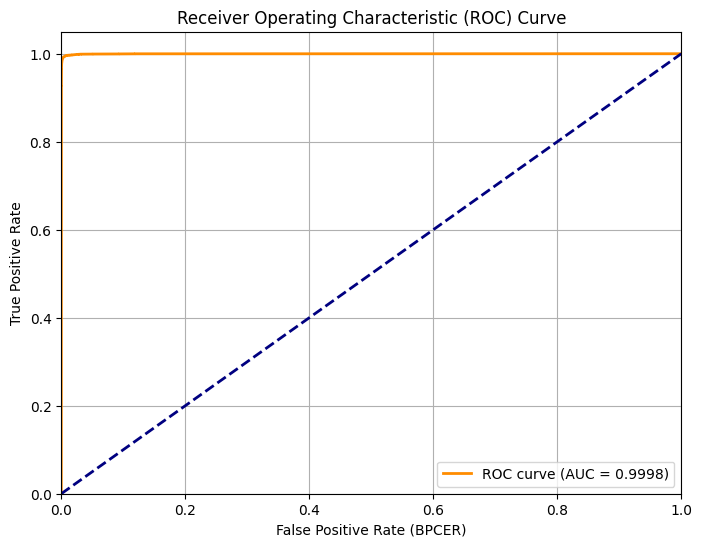

In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

def find_best_acer_and_metrics(y_true, y_pred_scores):
    """
    Mencari threshold optimal untuk ACER minimum, dengan asumsi
    SPOOF = 1 (kelas positif) dan REAL = 0 (kelas negatif).
    """
    # pos_label=1 sekarang merujuk ke kelas SPOOF
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_scores, pos_label=1)

    # === LOGIKA BARU (SPOOF = POSITIF) ===
    # APCER: Laju spoof (positif) yang salah diklasifikasikan sebagai real (negatif).
    # Ini adalah False Negative Rate (FNR).
    apcer = 1 - tpr

    # BPCER: Laju real (negatif) yang salah diklasifikasikan sebagai spoof (positif).
    # Ini adalah False Positive Rate (FPR).
    bpcer = fpr

    # ACER: Rata-rata dari kedua error.
    acer = (apcer + bpcer) / 2.0
    # ====================================

    # Cari threshold dengan ACER terendah
    best_idx = np.argmin(acer)
    best_acer = acer[best_idx]
    best_apcer = apcer[best_idx]
    best_bpcer = bpcer[best_idx]
    best_threshold = thresholds[best_idx]

    roc_auc = auc(fpr, tpr)

    # Hitung metrik lain pada threshold terbaik
    y_pred_binary = (y_pred_scores >= best_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    f1_score = 2 * (tp / (tp + fp) if (tp + fp) > 0 else 0) * (tp / (tp + fn) if (tp + fn) > 0 else 0) / ((tp / (tp + fp) if (tp + fp) > 0 else 0) + (tp / (tp + fn) if (tp + fn) > 0 else 0)) if ((tp / (tp + fp) if (tp + fp) > 0 else 0) + (tp / (tp + fn) if (tp + fn) > 0 else 0)) > 0 else 0


    # Kumpulkan metrik untuk disimpan ke JSON
    metrics = {
        'ACER': best_acer,
        'APCER': best_apcer,
        'BPCER': best_bpcer,
        'Optimal_Threshold': best_threshold,
        'AUC': roc_auc,
        'Accuracy_at_Best_ACER': accuracy,
        'F1_Score_at_Best_ACER': f1_score,
        'roc_curve_data': {
            'fpr': fpr.tolist(),
            'tpr': tpr.tolist()
        }
    }

    # Konversi tipe data NumPy agar kompatibel dengan JSON
    serializable_metrics = {}
    for key, value in metrics.items():
        if isinstance(value, np.generic):
            serializable_metrics[key] = value.item()
        else:
            serializable_metrics[key] = value

    return serializable_metrics

# Contoh y_true & y_pred_scores dari DataLoader:
model.eval()
all_labels = []
all_scores = []

model.eval()
with torch.no_grad():
    pbar = tqdm(test_loader, desc="Evaluating", leave=True)
    for batch in pbar:
        x, y = batch
        rgb = x['rgb'].to(device)
        ir = x['ir'].to(device)
        depth = x['depth'].to(device)
        y = y.to(device).unsqueeze(1)

        preds = model(rgb, depth, ir)

        all_labels.extend(y.cpu().numpy().flatten())
        all_scores.extend(preds.cpu().numpy().flatten())

y_true = np.array(all_labels)
y_pred_scores = np.array(all_scores)

metrics = find_best_acer_and_metrics(y_true, y_pred_scores)

print("\n--- Evaluation Metrics ---")
print(f"Optimal Threshold for Best ACER: {metrics['Optimal_Threshold']:.6f}")
print(f"Accuracy (at Best ACER): {metrics['Accuracy_at_Best_ACER']:.6f}")
print(f"AUC: {metrics['AUC']:.6f}")
print(f"F1 Score (at Best ACER): {metrics['F1_Score_at_Best_ACER']:.6f}")
print("-" * 20)
print(f"APCER (at Best ACER): {metrics['APCER']:.6f}")
print(f"BPCER (at Best ACER): {metrics['BPCER']:.6f}")
print(f"ACER (Average of APCER and BPCER): {metrics['ACER']:.6f}")
print("--------------------------\n")

# Ambil data dengan cara yang benar
roc_data = metrics['roc_curve_data']
fpr = roc_data['fpr']
tpr = roc_data['tpr']
roc_auc = metrics['AUC']

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (BPCER)')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
import os
import json
from pathlib import Path
from IPython.display import FileLink # Import FileLink

# Path folder Downloads user
downloads_folder = Path.home() / "Downloads"
downloads_folder.mkdir(exist_ok=True)  # pastikan folder ada

# Nama file output
OUTPUT_PATH = "D:/Krisna/MODELS/ResNet18_CA"
os.makedirs(OUTPUT_PATH, exist_ok=True)
OUTPUT_MODEL_PATH_LOCAL = os.path.join(OUTPUT_PATH, "Uni_CA.pth")
OUTPUT_JSON_PATH_LOCAL = os.path.join(OUTPUT_PATH, "Eval_Result_Uni_CA.json")
# OUTPUT_MODEL_PATH_LOCAL = casia_list_dir / "CA_ResNet18_LateFusionAdd_128_4.pth"
# OUTPUT_JSON_PATH_LOCAL = casia_list_dir / "Eval_Result_CA_ResNet18_LateFusionAdd_128_4.json"

# Simpan file pth
torch.save(model.state_dict(), OUTPUT_MODEL_PATH_LOCAL)
print(f"✅ Hasil evaluasi tersimpan di: {OUTPUT_MODEL_PATH_LOCAL}")


# Simpan file JSON
with open(OUTPUT_JSON_PATH_LOCAL, 'w') as f:
    json.dump(metrics, f, indent=4)

print(f"✅ Hasil evaluasi tersimpan di: {OUTPUT_JSON_PATH_LOCAL}")

# --- Tampilkan hasil di konsol ---
print("\n--- Hasil Evaluasi ---")
for key, value in metrics.items():
    if key != 'roc_curve_data':
        # Format angka jika float
        if isinstance(value, float):
            print(f"{key}: {value:.6f}")
        else:
            print(f"{key}: {value}")
print("------------------------\n")


# # Simpan ke file JSON di Google Drive
# os.makedirs(os.path.dirname(OUTPUT_JSON_PATH_DRIVE), exist_ok=True)
# with open(OUTPUT_JSON_PATH_DRIVE, 'w') as f:
#     json.dump(metrics, f, indent=4)
# print(f"✅ Hasil evaluasi berhasil disimpan di: {OUTPUT_JSON_PATH_DRIVE}")

# Simpan ke file JSON di local Colab session
os.makedirs(os.path.dirname(OUTPUT_JSON_PATH_LOCAL), exist_ok=True)
with open(OUTPUT_JSON_PATH_LOCAL, 'w') as f:
    json.dump(metrics, f, indent=4)
print(f"✅ Hasil evaluasi berhasil disimpan di: {OUTPUT_JSON_PATH_LOCAL}")

FileLink(OUTPUT_JSON_PATH_LOCAL)  # klik link yang muncul untuk download



✅ Hasil evaluasi tersimpan di: D:/Krisna/MODELS/ResNet18_CA\Uni_CA.pth
✅ Hasil evaluasi tersimpan di: D:/Krisna/MODELS/ResNet18_CA\Eval_Result_Uni_CA.json

--- Hasil Evaluasi ---
ACER: 0.005479
APCER: 0.006014
BPCER: 0.004944
Optimal_Threshold: 16.128487
AUC: 0.999788
Accuracy_at_Best_ACER: 0.994732
F1_Score_at_Best_ACER: 0.991317
------------------------

✅ Hasil evaluasi berhasil disimpan di: D:/Krisna/MODELS/ResNet18_CA\Eval_Result_Uni_CA.json


D:\Krisna\MODELS\ResNet18_CA\Eval_Result_Uni_CA.json

In [ ]:
# # # code baru
# import os
# from google.colab import drive
# import torch

# # Define the save directory within Google Drive
# # Make sure the 'MODELS' folder exists in your Google Drive
# drive_save_dir = "/content/drive/My Drive/Riset-FAS/MODELS/" #INI PATH DRIVE

# # Create the directory if it doesn't exist
# os.makedirs(drive_save_dir, exist_ok=True)

# # Define the save path in local Colab session storage
# local_save_path = "/content/MODELS/CA_MultiLevel.pth"

# # Create the local directory if it doesn't exist
# local_save_dir = os.path.dirname(local_save_path)
# os.makedirs(local_save_dir, exist_ok=True)


# # Save the model state dictionary to Google Drive
# torch.save(model.state_dict(), os.path.join(drive_save_dir, "_CA_ResNet18_MultiLevel_New.pth")) #INI PATH DRIVE
# print(f"Model state dictionary saved to Google Drive: {os.path.join(drive_save_dir, '_CA_ResNet18_MultiLevel_New.pth')}")

# # Save the model state dictionary to local Colab session storage
# torch.save(model.state_dict(), local_save_path)
# print(f"Model state dictionary saved to local Colab session: {local_save_path}")

In [ ]:
# import json

# # ===================================================================
# # 1. KONFIGURASI & SETUP
# # ===================================================================
# print("Memulai skrip pengujian model...")

# # --- Path Konfigurasi ---
# MODEL_PATH = "/content/MODELS/CA_MultiLevel.pth" #GAUSAH GANTI SELAIN GANTI MODEL
# TEST_ANNOTATIONS_PATH = "/content/drive/My Drive/Riset-FAS/DIRS-KAGGLE/test_dirs.txt"
# TEST_BASE_DIR = "/root/.cache/kagglehub/datasets/sayangsanie/test-casia-2/versions/1/"

# OUTPUT_JSON_PATH_DRIVE = "/content/drive/My Drive/Riset-FAS/MODELS/Eval_CA_ResNet18_MultiLevel_New.json" #INI DRIVE
# OUTPUT_JSON_PATH_LOCAL = "/content/MODELS/Eval_Result_CA_MultiLevel_ResNet18.json" #GAUSAH GANTI SELAIN GANTI MODEL

# # --- Tampilkan hasil di konsol ---
# print("\n--- Hasil Evaluasi ---")
# for key, value in metrics.items():
#     if key != 'roc_curve_data':
#         # Format angka jika float
#         if isinstance(value, float):
#             print(f"{key}: {value:.6f}")
#         else:
#             print(f"{key}: {value}")
# print("------------------------\n")


# # Simpan ke file JSON di Google Drive
# os.makedirs(os.path.dirname(OUTPUT_JSON_PATH_DRIVE), exist_ok=True)
# with open(OUTPUT_JSON_PATH_DRIVE, 'w') as f:
#     json.dump(metrics, f, indent=4)
# print(f"✅ Hasil evaluasi berhasil disimpan di: {OUTPUT_JSON_PATH_DRIVE}")

# # Simpan ke file JSON di local Colab session
# os.makedirs(os.path.dirname(OUTPUT_JSON_PATH_LOCAL), exist_ok=True)
# with open(OUTPUT_JSON_PATH_LOCAL, 'w') as f:
#     json.dump(metrics, f, indent=4)
# print(f"✅ Hasil evaluasi berhasil disimpan di: {OUTPUT_JSON_PATH_LOCAL}")

In [ ]:
# import torch
# import torch.nn as nn
# import pandas as pd
# import numpy as np
# import os
# import json
# from tqdm import tqdm
# from sklearn.metrics import roc_curve, auc, confusion_matrix
# from torch.utils.data import DataLoader

# # ===================================================================
# # 1. KONFIGURASI & SETUP
# # ===================================================================
# print("Memulai skrip pengujian model...")

# # --- Path Konfigurasi ---
# MODEL_PATH = "/content/MODELS/MobileNetV2.pth" #GAUSAH GANTI SELAIN GANTI MODEL
# TEST_ANNOTATIONS_PATH = "/content/drive/My Drive/Riset-FAS/DIRS-KAGGLE/test_dirs.txt"
# TEST_BASE_DIR = "/root/.cache/kagglehub/datasets/sayangsanie/test-casia-2/versions/1/"

# OUTPUT_JSON_PATH_DRIVE = "/content/drive/My Drive/Riset-FAS/MODELS_NO_WEIGHTS/Eval_Result_CA_MobileNetV2_320.json" #INI DRIVE
# OUTPUT_JSON_PATH_LOCAL = "/content/MODELS/Eval_Result_CA_MobileNetV2.json" #GAUSAH GANTI SELAIN GANTI MODEL


# # ===================================================================
# # 2. FUNGSI PERHITUNGAN METRIK (ACER, APCER, BPCER, AUC, dll.)
# # ===================================================================

# def find_best_acer_and_metrics(y_true, y_pred_scores):
#     """
#     Mencari threshold optimal untuk ACER minimum, dengan asumsi
#     SPOOF = 1 (kelas positif) dan REAL = 0 (kelas negatif).
#     """
#     # pos_label=1 sekarang merujuk ke kelas SPOOF
#     fpr, tpr, thresholds = roc_curve(y_true, y_pred_scores, pos_label=1)

#     # === LOGIKA BARU (SPOOF = POSITIF) ===
#     # APCER: Laju spoof (positif) yang salah diklasifikasikan sebagai real (negatif).
#     # Ini adalah False Negative Rate (FNR).
#     apcer = 1 - tpr

#     # BPCER: Laju real (negatif) yang salah diklasifikasikan sebagai spoof (positif).
#     # Ini adalah False Positive Rate (FPR).
#     bpcer = fpr

#     # ACER: Rata-rata dari kedua error.
#     acer = (apcer + bpcer) / 2.0
#     # ====================================

#     # Cari threshold dengan ACER terendah
#     best_idx = np.argmin(acer)
#     best_acer = acer[best_idx]
#     best_apcer = apcer[best_idx]
#     best_bpcer = bpcer[best_idx]
#     best_threshold = thresholds[best_idx]

#     roc_auc = auc(fpr, tpr)

#     # Hitung metrik lain pada threshold terbaik
#     y_pred_binary = (y_pred_scores >= best_threshold).astype(int)
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
#     accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
#     f1_score = 2 * (tp / (tp + fp) if (tp + fp) > 0 else 0) * (tp / (tp + fn) if (tp + fn) > 0 else 0) / ((tp / (tp + fp) if (tp + fp) > 0 else 0) + (tp / (tp + fn) if (tp + fn) > 0 else 0)) if ((tp / (tp + fp) if (tp + fp) > 0 else 0) + (tp / (tp + fn) if (tp + fn) > 0 else 0)) > 0 else 0


#     # Kumpulkan metrik untuk disimpan ke JSON
#     metrics = {
#         'ACER': best_acer,
#         'APCER': best_apcer,
#         'BPCER': best_bpcer,
#         'Optimal_Threshold': best_threshold,
#         'AUC': roc_auc,
#         'Accuracy_at_Best_ACER': accuracy,
#         'F1_Score_at_Best_ACER': f1_score,
#         'roc_curve_data': {
#             'fpr': fpr.tolist(),
#             'tpr': tpr.tolist()
#         }
#     }

#     # Konversi tipe data NumPy agar kompatibel dengan JSON
#     serializable_metrics = {}
#     for key, value in metrics.items():
#         if isinstance(value, np.generic):
#             serializable_metrics[key] = value.item()
#         else:
#             serializable_metrics[key] = value

#     return serializable_metrics

# # ===================================================================
# # 3. MEMUAT MODEL DAN DATA
# # ===================================================================
# print("Memuat model dan data...")

# # --- Inisialisasi Model ---
# # Ganti parameter jika model Anda berbeda
# # model = FlexibleMultiPathFusionModel(embed_dim=160, num_heads=8).to(DEVICE) # Changed embed_dim to 160
# # model = SimpleAddFusionModel(embed_dim=128).to(device)
# model = MultiPathFusionModel(embed_dim=320, num_heads=10, use_projection=True).to(device)

# # --- Memuat Bobot yang Sudah Dilatih ---
# model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
# model.eval() # PENTING: Set model ke mode evaluasi
# print("Model berhasil dimuat dan disetel ke mode evaluasi.")

# # --- Memuat Dataset & DataLoader ---
# data_test = pd.read_csv(TEST_ANNOTATIONS_PATH, header=None, sep=' ')
# data_test.columns = ['color_file', 'depth_file', 'ir_file', 'label']

# # Use the MultiModalDataset class defined earlier
# test_ds = MultiModalDataset(data_test, TEST_BASE_DIR)
# test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
# print(f"Data tes berhasil dimuat dengan {len(test_ds)} sampel.")

# # ===================================================================
# # 4. PROSES EVALUASI
# # ===================================================================
# print("\nMemulai proses evaluasi pada data tes...")
# all_labels = []
# all_scores = []

# with torch.no_grad(): # PENTING: Tidak perlu menghitung gradien saat evaluasi
#     pbar = tqdm(test_loader, desc="Mengevaluasi", leave=True)
#     for batch in pbar:
#         x, y = batch
#         rgb = x['rgb'].to(DEVICE)
#         ir = x['ir'].to(DEVICE)
#         depth = x['depth'].to(DEVICE)

#         preds = model(rgb, depth, ir)
#         # preds = model(rgb, depth)

#         all_labels.extend(y.numpy().flatten())
#         all_scores.extend(preds.cpu().numpy().flatten())
# print("Evaluasi selesai.")

# # ===================================================================
# # 5. MENGHITUNG METRIK DAN MENYIMPAN HASIL
# # ===================================================================
# print("Menghitung metrik akhir...")
# y_true = np.array(all_labels)
# y_pred_scores = np.array(all_scores)

# # Hitung semua metrik menggunakan fungsi yang sudah disiapkan
# final_metrics = find_best_acer_and_metrics(y_true, y_pred_scores)
# print("Metrik berhasil dihitung.")

# # --- Tampilkan hasil di konsol ---
# print("\n--- Hasil Evaluasi ---")
# for key, value in final_metrics.items():
#     if key != 'roc_curve_data':
#         # Format angka jika float
#         if isinstance(value, float):
#             print(f"{key}: {value:.6f}")
#         else:
#             print(f"{key}: {value}")
# print("------------------------\n")


# # Simpan ke file JSON di Google Drive
# os.makedirs(os.path.dirname(OUTPUT_JSON_PATH_DRIVE), exist_ok=True)
# with open(OUTPUT_JSON_PATH_DRIVE, 'w') as f:
#     json.dump(final_metrics, f, indent=4)
# print(f"✅ Hasil evaluasi berhasil disimpan di: {OUTPUT_JSON_PATH_DRIVE}")

# # Simpan ke file JSON di local Colab session
# os.makedirs(os.path.dirname(OUTPUT_JSON_PATH_LOCAL), exist_ok=True)
# with open(OUTPUT_JSON_PATH_LOCAL, 'w') as f:
#     json.dump(final_metrics, f, indent=4)
# print(f"✅ Hasil evaluasi berhasil disimpan di: {OUTPUT_JSON_PATH_LOCAL}")

In [ ]:
# import json
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.metrics import auc # Hanya butuh auc untuk plot

# def display_metrics_from_file(filepath):
#     """
#     Memuat metrik yang SUDAH JADI dari file JSON dan menampilkannya.
#     """
#     try:
#         with open(filepath, 'r') as f:
#             data = json.load(f)
#     except FileNotFoundError:
#         print(f"❌ ERROR: File tidak ditemukan di {filepath}")
#         return
#     except json.JSONDecodeError:
#         print(f"❌ ERROR: File {filepath} bukan file JSON yang valid.")
#         return

#     print(f"\n📁 Menampilkan metrik dari: {filepath}")

#     # === LANGSUNG BACA METRIK YANG SUDAH JADI ===
#     # Tidak perlu menghitung ulang, cukup ambil dari data
#     try:
#         model_name = filepath  # Gunakan nama file sebagai nama model
#         roc_auc = data['AUC']
#         accuracy = data['Accuracy_at_Best_ACER']
#         f1 = data['F1_Score_at_Best_ACER']
#         acer = data['ACER']
#         apcer = data['APCER']
#         bpcer = data['BPCER']
#         optimal_threshold = data['Optimal_Threshold']

#         # Ambil data kurva ROC untuk plot
#         fpr = np.array(data['roc_curve_data']['fpr'])
#         tpr = np.array(data['roc_curve_data']['tpr'])
#     except KeyError as e:
#         print(f"❌ ERROR: Kunci {e} tidak ditemukan di file JSON. Pastikan file JSON memiliki semua metrik yang diperlukan.")
#         return

#     # === Tampilkan metrik dalam tabel ===
#     metrics_data = {
#         'Model': model_name,
#         'AUC': f"{roc_auc:.4f}",
#         'Accuracy': f"{accuracy:.4f}",
#         'F1-Score (Spoof)': f"{f1:.4f}",
#         'ACER': f"{acer:.4f}",
#         'APCER': f"{apcer:.4f}",
#         'BPCER': f"{bpcer:.4f}",
#         'Optimal Threshold': f"{optimal_threshold:.4f}"
#     }

#     metrics_df = pd.DataFrame([metrics_data])
#     print("\n📊 Ringkasan Evaluasi:")
#     print(metrics_df.to_string(index=False))

#     # === Visualisasi ROC Curve ===
#     plt.figure(figsize=(8, 8)) # Ukuran diubah karena hanya ada 1 plot
#     plt.title(f'ROC Curve for {model_name}', fontsize=16)

#     plt.plot(fpr, tpr, lw=2, color='darkorange', label=f'ROC Curve (AUC = {roc_auc:.4f})')
#     plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')

#     # Cari titik optimal di plot
#     # Kita perlu mencari ulang indeksnya di fpr/tpr karena nilainya mungkin tidak sama persis
#     optimal_tpr_val = 1 - apcer
#     # Cari tpr yang paling dekat dengan nilai optimal
#     optimal_idx = np.argmin(np.abs(tpr - optimal_tpr_val))

#     plt.scatter(bpcer, tpr[optimal_idx], s=100, color='red', zorder=5, label=f'Best ACER Point (Thr={optimal_threshold:.4f})')

#     plt.xlabel('False Positive Rate (BPCER)')
#     plt.ylabel('True Positive Rate (1 - APCER)')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # --- Jalankan fungsi dengan file Anda ---
# filepath = '/content/Models/Eval_Result_CA_MobileNetV2.json'


# display_metrics_from_file(filepath)

In [ ]:
# from google.colab import drive
# from IPython.display import Javascript
# import time
# import os

# # Paksa simpan notebook dulu
# def save_notebook():
#     display(Javascript('''google.colab.kernel.invokeFunction('notebook.save', [], {});'''))

# save_notebook()
# time.sleep(10)  # Tunggu biar simpan selesai


# # Define path
# notebook_path = '/content/drive/My Drive/Riset-FAS/(Krisna)_Cross_attention.ipynb'
# drive_save_path = '/content/drive/My Drive/Riset-FAS/NOTEBOOK/ResNet18/(Krisna)_CA_ResNet18_MultiLevel_New.ipynb'

# # Copy file
# !cp "$notebook_path" "$drive_save_path"

# print(f"Notebook saved to Google Drive at: {drive_save_path}")
